## 📦 Importar Bibliotecas

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


## 🎲 Criar Dataset de Exemplo

Vamos criar um dataset sintético com diferentes tipos de distribuições.

In [13]:
np.random.seed(42)
n_samples = 1000

# Criar features com diferentes distribuições
df = pd.DataFrame({
    # Feature normal
    'idade': np.random.normal(35, 10, n_samples).clip(18, 80).astype(int),
    
    # Feature com distribuição assimétrica (log-normal)
    'salario': np.random.lognormal(10, 0.5, n_samples).astype(int),
    
    # Feature com outliers
    'horas_trabalho': np.concatenate([
        np.random.normal(40, 5, int(n_samples * 0.95)),
        np.random.uniform(60, 100, int(n_samples * 0.05))
    ]),
    
    # Feature em escala diferente
    'anos_experiencia': np.random.uniform(0, 20, n_samples),
    
    # Feature com range grande
    'distancia_casa_km': np.random.exponential(15, n_samples).clip(0, 100)
})

# Target: satisfação no trabalho (0 ou 1)
# Baseado em regras simples para ter padrões
df['satisfeito'] = (
    (df['salario'] > df['salario'].median()) & 
    (df['horas_trabalho'] < 50) &
    (df['distancia_casa_km'] < 30)
).astype(int)

# Adicionar aleatoriedade
noise = np.random.random(n_samples) < 0.1
df.loc[noise, 'satisfeito'] = 1 - df.loc[noise, 'satisfeito']

print(f"✅ Dataset criado: {df.shape[0]} linhas, {df.shape[1]} colunas")
print(f"\n📊 Distribuição do target:")
print(df['satisfeito'].value_counts())
print(f"\n📈 Primeiras linhas:")
df.head()

✅ Dataset criado: 1000 linhas, 6 colunas

📊 Distribuição do target:
satisfeito
0    582
1    418
Name: count, dtype: int64

📈 Primeiras linhas:


,idade,salario,horas_trabalho,anos_experiencia,distancia_casa_km,satisfeito
0,39,44341,36.624109,11.537148,31.300609,0
1,33,34972,39.277407,9.279634,35.355461,0
2,41,22693,36.037900,2.374182,10.187391,0
3,50,15939,38.460192,19.611365,6.010655,0
4,32,31229,30.531927,4.293918,1.694183,1


## 📊 Análise Exploratória das Distribuições

📊 Estatísticas Descritivas:

         idade    salario  horas_trabalho  anos_experiencia  \
count  1000.00    1000.00         1000.00           1000.00   
mean     34.82   25815.00           42.06              9.82   
std       9.49   13535.64           10.44              5.72   
min      18.00    5063.00           24.90              0.00   
25%      28.00   16266.50           36.96              4.89   
50%      35.00   22732.00           40.25              9.70   
75%      41.00   31711.00           43.80             14.59   
max      73.00  108722.00           97.26             19.95   

       distancia_casa_km  satisfeito  
count            1000.00     1000.00  
mean               14.83        0.42  
std                14.59        0.49  
min                 0.01        0.00  
25%                 4.26        0.00  
50%                 9.93        0.00  
75%                20.37        1.00  
max               100.00        1.00  


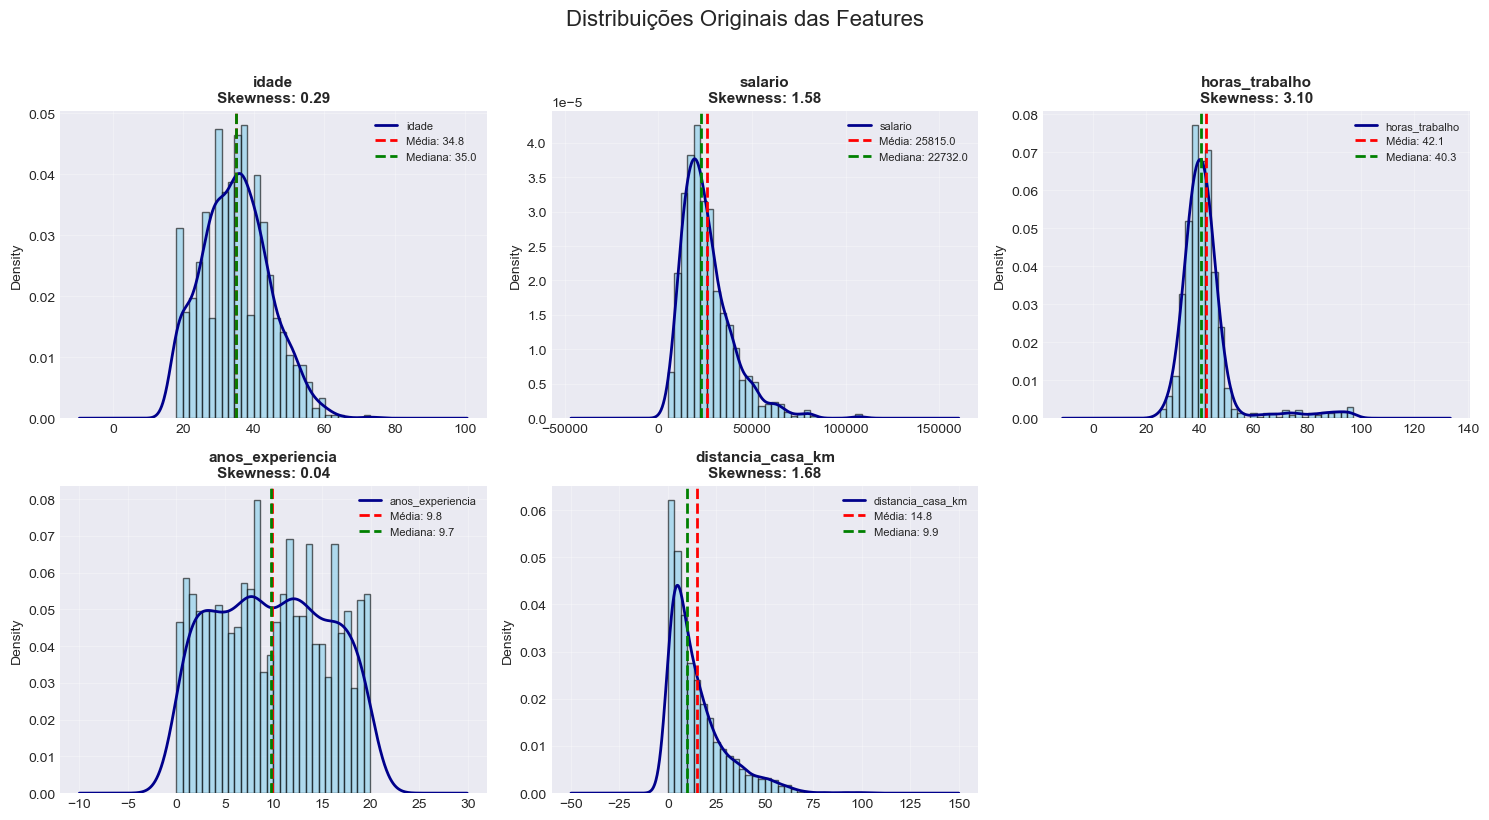


📌 Observações:
- 'idade': Distribuição aproximadamente normal
- 'salario': Distribuição assimétrica positiva (log-normal)
- 'horas_trabalho': Outliers à direita
- 'anos_experiencia': Distribuição uniforme
- 'distancia_casa_km': Distribuição exponencial


In [14]:
# Estatísticas descritivas
print("📊 Estatísticas Descritivas:\n")
print(df.describe().round(2))

# Visualizar distribuições
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Distribuições Originais das Features', fontsize=16, y=1.02)

features = ['idade', 'salario', 'horas_trabalho', 'anos_experiencia', 'distancia_casa_km']

for idx, col in enumerate(features):
    ax = axes[idx // 3, idx % 3]
    
    # Histograma + KDE
    ax.hist(df[col], bins=30, alpha=0.6, color='skyblue', edgecolor='black', density=True)
    df[col].plot(kind='kde', ax=ax, color='darkblue', linewidth=2)
    
    # Estatísticas
    mean_val = df[col].mean()
    median_val = df[col].median()
    skew_val = df[col].skew()
    
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Média: {mean_val:.1f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.1f}')
    
    ax.set_title(f'{col}\nSkewness: {skew_val:.2f}', fontsize=11, fontweight='bold')
    ax.set_xlabel('')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Remover subplot vazio
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

print("\n📌 Observações:")
print("- 'idade': Distribuição aproximadamente normal")
print("- 'salario': Distribuição assimétrica positiva (log-normal)")
print("- 'horas_trabalho': Outliers à direita")
print("- 'anos_experiencia': Distribuição uniforme")
print("- 'distancia_casa_km': Distribuição exponencial")

## 🔄 1. Scaling e Normalização

### 1.1 StandardScaler (Z-score)

✅ StandardScaler aplicado!

📊 Estatísticas após StandardScaler:
       idade_standard  salario_standard  horas_trabalho_standard  \
count         1000.00           1000.00                  1000.00   
mean            -0.00             -0.00                     0.00   
std              1.00              1.00                     1.00   
min             -1.77             -1.53                    -1.64   
25%             -0.72             -0.71                    -0.49   
50%              0.02             -0.23                    -0.17   
75%              0.65              0.44                     0.17   
max              4.02              6.13                     5.29   

       anos_experiencia_standard  distancia_casa_km_standard  
count                    1000.00                     1000.00  
mean                       -0.00                       -0.00  
std                         1.00                        1.00  
min                        -1.72                       -1.02  
25%     

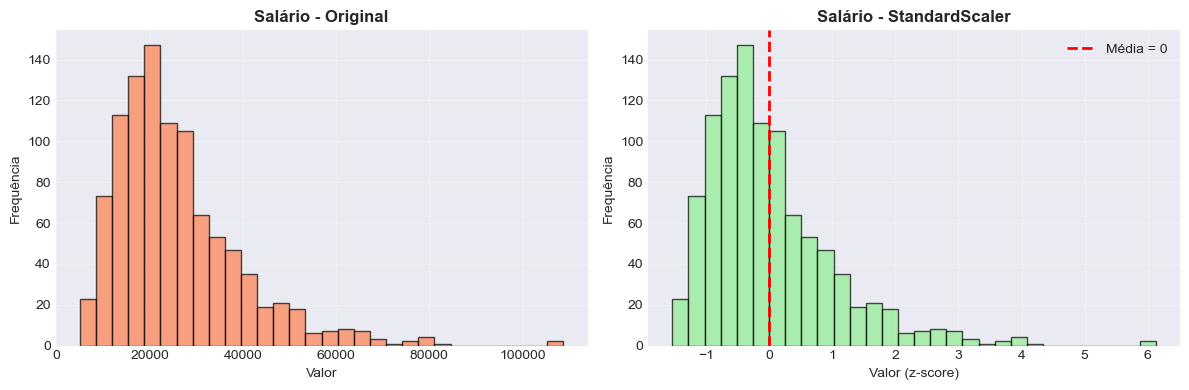


📌 StandardScaler:
✅ Média = 0, Desvio Padrão = 1
✅ Mantém forma da distribuição
✅ Sensível a outliers


In [15]:
# Preparar dados
X = df[features]
y = df['satisfeito']

# StandardScaler
scaler_standard = StandardScaler()
X_standard = pd.DataFrame(
    scaler_standard.fit_transform(X),
    columns=[f'{col}_standard' for col in X.columns]
)

print("✅ StandardScaler aplicado!\n")
print("📊 Estatísticas após StandardScaler:")
print(X_standard.describe().round(2))

# Visualizar transformação
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Antes
axes[0].hist(X['salario'], bins=30, alpha=0.7, color='coral', edgecolor='black')
axes[0].set_title('Salário - Original', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frequência')
axes[0].grid(True, alpha=0.3)

# Depois
axes[1].hist(X_standard['salario_standard'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].set_title('Salário - StandardScaler', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Valor (z-score)')
axes[1].set_ylabel('Frequência')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Média = 0')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📌 StandardScaler:")
print("✅ Média = 0, Desvio Padrão = 1")
print("✅ Mantém forma da distribuição")
print("✅ Sensível a outliers")

### 1.2 MinMaxScaler

✅ MinMaxScaler aplicado!

📊 Estatísticas após MinMaxScaler:
       idade_minmax  salario_minmax  horas_trabalho_minmax  \
count       1000.00         1000.00                1000.00   
mean           0.31            0.20                   0.24   
std            0.17            0.13                   0.14   
min            0.00            0.00                   0.00   
25%            0.18            0.11                   0.17   
50%            0.31            0.17                   0.21   
75%            0.42            0.26                   0.26   
max            1.00            1.00                   1.00   

       anos_experiencia_minmax  distancia_casa_km_minmax  
count                  1000.00                   1000.00  
mean                      0.49                      0.15  
std                       0.29                      0.15  
min                       0.00                      0.00  
25%                       0.25                      0.04  
50%                       0

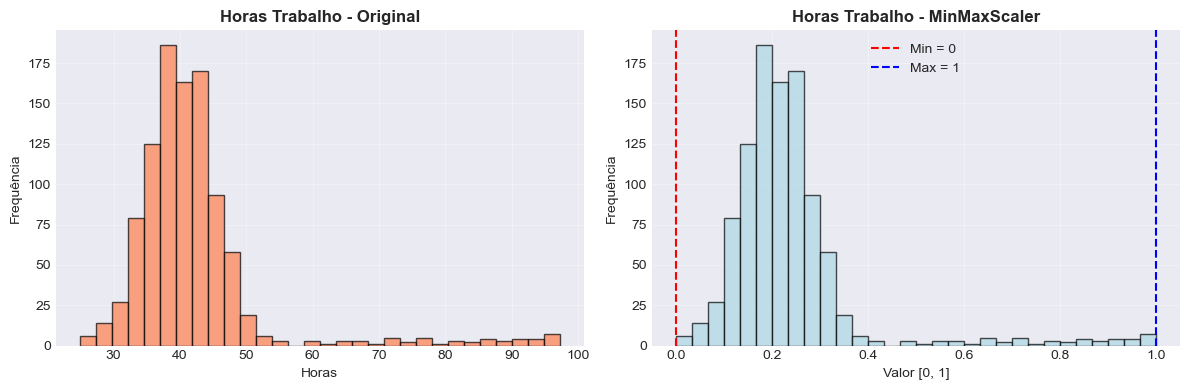


📌 MinMaxScaler:
✅ Range [0, 1]
✅ Mantém forma da distribuição
⚠️ Muito sensível a outliers


In [16]:
# MinMaxScaler
scaler_minmax = MinMaxScaler()
X_minmax = pd.DataFrame(
    scaler_minmax.fit_transform(X),
    columns=[f'{col}_minmax' for col in X.columns]
)

print("✅ MinMaxScaler aplicado!\n")
print("📊 Estatísticas após MinMaxScaler:")
print(X_minmax.describe().round(2))

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(X['horas_trabalho'], bins=30, alpha=0.7, color='coral', edgecolor='black')
axes[0].set_title('Horas Trabalho - Original', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Horas')
axes[0].set_ylabel('Frequência')
axes[0].grid(True, alpha=0.3)

axes[1].hist(X_minmax['horas_trabalho_minmax'], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
axes[1].set_title('Horas Trabalho - MinMaxScaler', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Valor [0, 1]')
axes[1].set_ylabel('Frequência')
axes[1].axvline(0, color='red', linestyle='--', linewidth=1.5, label='Min = 0')
axes[1].axvline(1, color='blue', linestyle='--', linewidth=1.5, label='Max = 1')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📌 MinMaxScaler:")
print("✅ Range [0, 1]")
print("✅ Mantém forma da distribuição")
print("⚠️ Muito sensível a outliers")

### 1.3 RobustScaler

✅ RobustScaler aplicado!

📊 Estatísticas após RobustScaler:
       idade_robust  salario_robust  horas_trabalho_robust  \
count       1000.00         1000.00                1000.00   
mean          -0.01            0.20                   0.26   
std            0.73            0.88                   1.52   
min           -1.31           -1.14                  -2.24   
25%           -0.54           -0.42                  -0.48   
50%            0.00            0.00                  -0.00   
75%            0.46            0.58                   0.52   
max            2.92            5.57                   8.33   

       anos_experiencia_robust  distancia_casa_km_robust  
count                  1000.00                   1000.00  
mean                      0.01                      0.30  
std                       0.59                      0.91  
min                      -1.00                     -0.62  
25%                      -0.50                     -0.35  
50%                      -0

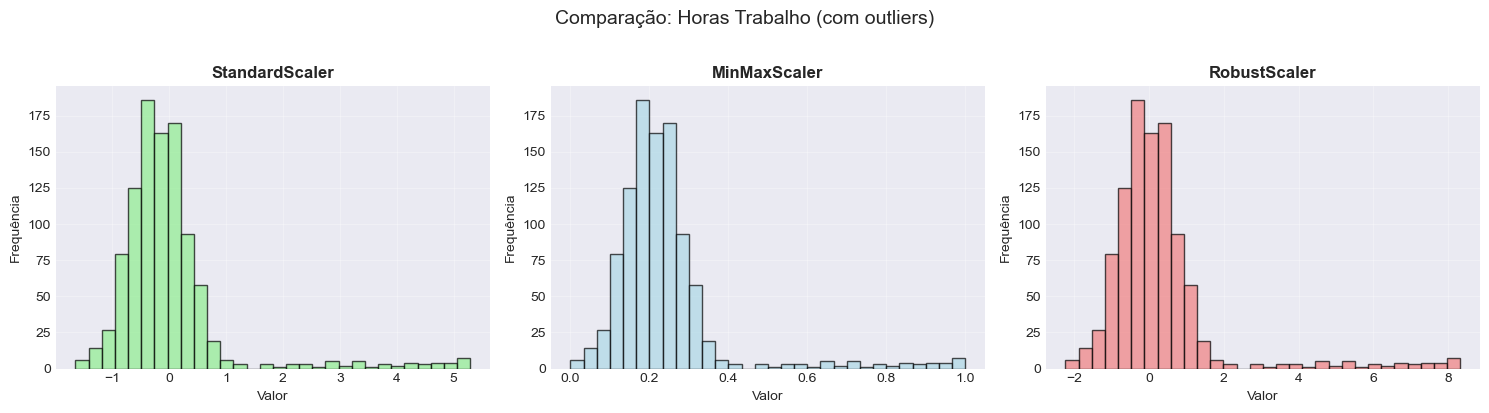


📌 RobustScaler:
✅ Usa mediana e IQR
✅ Resistente a outliers
✅ Melhor para dados com valores extremos


In [17]:
# RobustScaler
scaler_robust = RobustScaler()
X_robust = pd.DataFrame(
    scaler_robust.fit_transform(X),
    columns=[f'{col}_robust' for col in X.columns]
)

print("✅ RobustScaler aplicado!\n")
print("📊 Estatísticas após RobustScaler:")
print(X_robust.describe().round(2))

# Comparar os 3 scalers na feature com outliers
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(X_standard['horas_trabalho_standard'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0].set_title('StandardScaler', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frequência')
axes[0].grid(True, alpha=0.3)

axes[1].hist(X_minmax['horas_trabalho_minmax'], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
axes[1].set_title('MinMaxScaler', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Valor')
axes[1].set_ylabel('Frequência')
axes[1].grid(True, alpha=0.3)

axes[2].hist(X_robust['horas_trabalho_robust'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[2].set_title('RobustScaler', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Valor')
axes[2].set_ylabel('Frequência')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Comparação: Horas Trabalho (com outliers)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n📌 RobustScaler:")
print("✅ Usa mediana e IQR")
print("✅ Resistente a outliers")
print("✅ Melhor para dados com valores extremos")

## 📈 2. Transformações de Distribuição

### 2.1 Log Transform

✅ Log Transform aplicado!



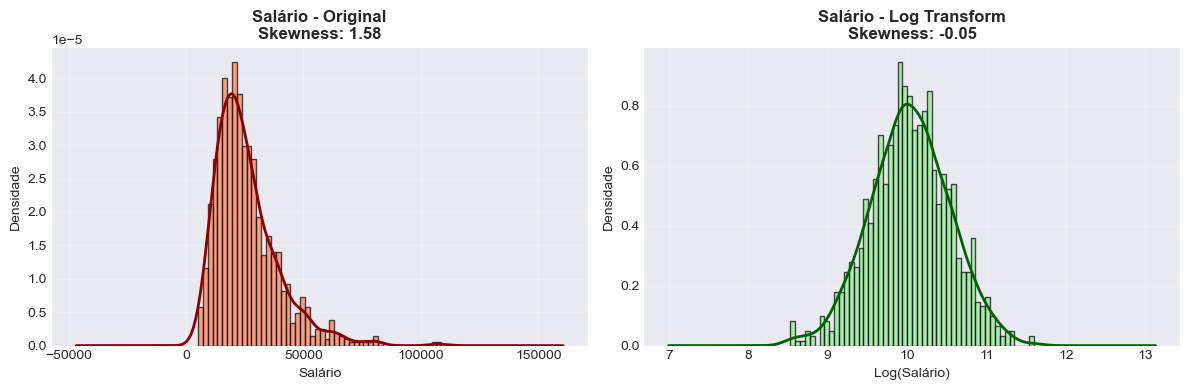


📊 Comparação:
Skewness Original: 1.575
Skewness Log:      -0.049

✅ Log Transform reduziu a assimetria!


In [18]:
# Log Transform no salário (distribuição assimétrica)
X_log = X.copy()
X_log['salario_log'] = np.log1p(X['salario'])  # log(1 + x) para evitar log(0)

print("✅ Log Transform aplicado!\n")

# Comparar distribuições
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original
axes[0].hist(X['salario'], bins=50, alpha=0.7, color='coral', edgecolor='black', density=True)
X['salario'].plot(kind='kde', ax=axes[0], color='darkred', linewidth=2)
axes[0].set_title(f"Salário - Original\nSkewness: {X['salario'].skew():.2f}", fontsize=12, fontweight='bold')
axes[0].set_xlabel('Salário')
axes[0].set_ylabel('Densidade')
axes[0].grid(True, alpha=0.3)

# Log Transform
axes[1].hist(X_log['salario_log'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black', density=True)
X_log['salario_log'].plot(kind='kde', ax=axes[1], color='darkgreen', linewidth=2)
axes[1].set_title(f"Salário - Log Transform\nSkewness: {X_log['salario_log'].skew():.2f}", fontsize=12, fontweight='bold')
axes[1].set_xlabel('Log(Salário)')
axes[1].set_ylabel('Densidade')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Comparação:")
print(f"Skewness Original: {X['salario'].skew():.3f}")
print(f"Skewness Log:      {X_log['salario_log'].skew():.3f}")
print("\n✅ Log Transform reduziu a assimetria!")

### 2.2 Box-Cox e Yeo-Johnson

✅ Yeo-Johnson aplicado!



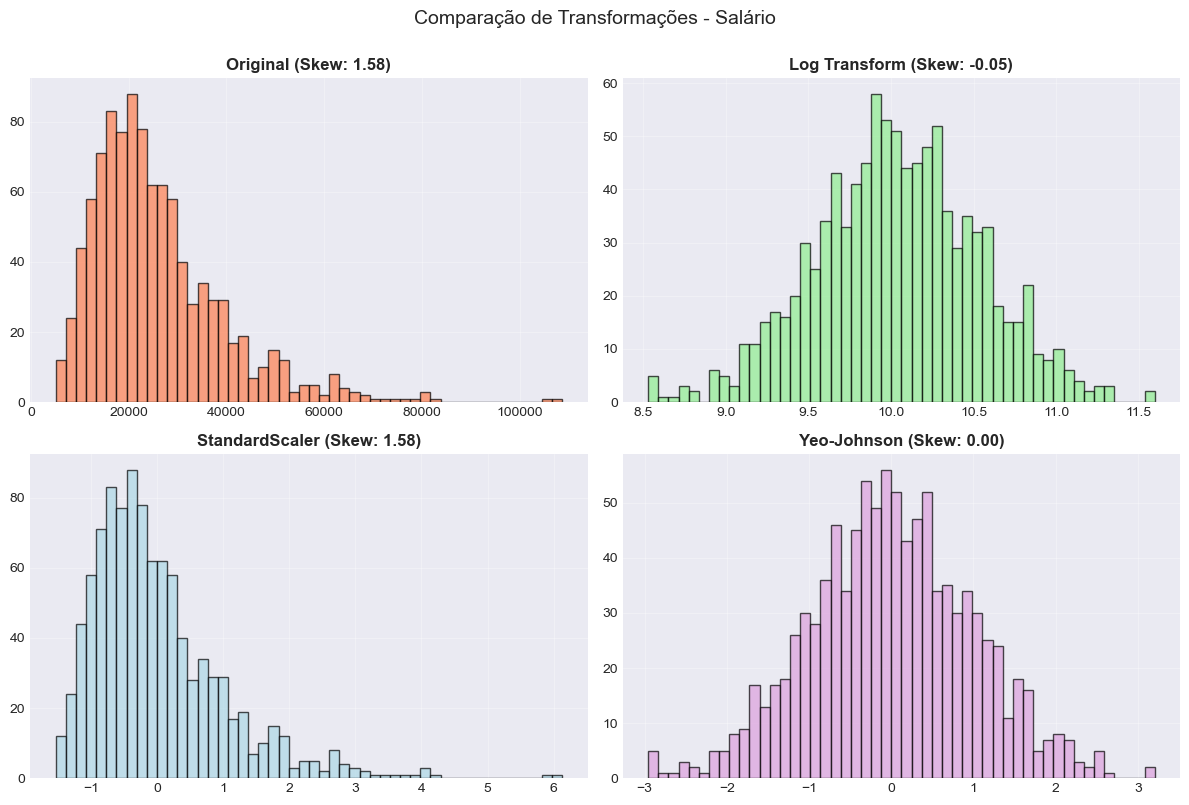


📊 Resumo das Transformações:
Original            : Skewness =  1.575
Log Transform       : Skewness = -0.049
StandardScaler      : Skewness =  1.575
Yeo-Johnson         : Skewness =  0.000

🏆 Melhor transformação: Yeo-Johnson (mais próximo de 0)


In [19]:
# Yeo-Johnson (aceita valores negativos)
pt_yeo = PowerTransformer(method='yeo-johnson')
X_yeo = pd.DataFrame(
    pt_yeo.fit_transform(X),
    columns=[f'{col}_yeo' for col in X.columns]
)

print("✅ Yeo-Johnson aplicado!\n")

# Comparar todas as transformações no salário
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Comparação de Transformações - Salário', fontsize=14, y=1.00)

# Original
axes[0, 0].hist(X['salario'], bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[0, 0].set_title(f"Original (Skew: {X['salario'].skew():.2f})", fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Log
axes[0, 1].hist(X_log['salario_log'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title(f"Log Transform (Skew: {X_log['salario_log'].skew():.2f})", fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# StandardScaler
axes[1, 0].hist(X_standard['salario_standard'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[1, 0].set_title(f"StandardScaler (Skew: {X_standard['salario_standard'].skew():.2f})", fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Yeo-Johnson
axes[1, 1].hist(X_yeo['salario_yeo'], bins=50, alpha=0.7, color='plum', edgecolor='black')
axes[1, 1].set_title(f"Yeo-Johnson (Skew: {X_yeo['salario_yeo'].skew():.2f})", fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Resumo das Transformações:")
transformations = {
    'Original': X['salario'].skew(),
    'Log Transform': X_log['salario_log'].skew(),
    'StandardScaler': X_standard['salario_standard'].skew(),
    'Yeo-Johnson': X_yeo['salario_yeo'].skew()
}

for name, skew in transformations.items():
    print(f"{name:20s}: Skewness = {skew:6.3f}")

best = min(transformations.items(), key=lambda x: abs(x[1]))
print(f"\n🏆 Melhor transformação: {best[0]} (mais próximo de 0)")

In [ ]:
from scipy.stats import probplot

# 🔍 Análise Detalhada: Quando e Por Que Usar Cada Transformação

print("="*80)
print("📚 GUIA COMPLETO: TRANSFORMAÇÕES DE DADOS")
print("="*80)

# 1. Análise de cada transformação
print("\n" + "="*80)
print("1️⃣ TRANSFORMAÇÕES DE ESCALA (SCALING)")
print("="*80)

# Comparação visual detalhada
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Análise Comparativa: Scaling vs Distribuição Original', fontsize=16, fontweight='bold', y=0.995)

# Feature com distribuição normal (idade)
axes[0, 0].hist(X['idade'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('IDADE - Original\n(Distribuição Normal)', fontweight='bold')
axes[0, 0].set_xlabel('Idade (anos)')
axes[0, 0].axvline(X['idade'].mean(), color='red', linestyle='--', linewidth=2, label=f"μ={X['idade'].mean():.1f}")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].boxplot([X_standard['idade_standard'], X_minmax['idade_minmax'], X_robust['idade_robust']], 
                     labels=['Standard', 'MinMax', 'Robust'], patch_artist=True)
axes[0, 1].set_title('IDADE - Após Scaling\n(Comparação)', fontweight='bold')
axes[0, 1].set_ylabel('Valores Transformados')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Feature assimétrica (salário)
axes[1, 0].hist(X['salario'], bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[1, 0].set_title(f'SALÁRIO - Original\n(Assimetria={X["salario"].skew():.2f})', fontweight='bold')
axes[1, 0].set_xlabel('Salário (R$)')
axes[1, 0].axvline(X['salario'].median(), color='green', linestyle='--', linewidth=2, label=f"Mediana={X['salario'].median():.0f}")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].boxplot([X_standard['salario_standard'], X_minmax['salario_minmax'], X_robust['salario_robust']], 
                     labels=['Standard', 'MinMax', 'Robust'], patch_artist=True)
axes[1, 1].set_title('SALÁRIO - Após Scaling\n(Comparação)', fontweight='bold')
axes[1, 1].set_ylabel('Valores Transformados')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Feature com outliers (horas trabalho)
axes[2, 0].hist(X['horas_trabalho'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[2, 0].set_title('HORAS TRABALHO - Original\n(Com Outliers)', fontweight='bold')
axes[2, 0].set_xlabel('Horas')
outlier_threshold = X['horas_trabalho'].quantile(0.95)
axes[2, 0].axvline(outlier_threshold, color='red', linestyle='--', linewidth=2, label=f"95% = {outlier_threshold:.1f}h")
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].boxplot([X_standard['horas_trabalho_standard'], X_minmax['horas_trabalho_minmax'], X_robust['horas_trabalho_robust']], 
                     labels=['Standard', 'MinMax', 'Robust'], patch_artist=True)
axes[2, 1].set_title('HORAS TRABALHO - Após Scaling\n(Note: Robust mais estável)', fontweight='bold')
axes[2, 1].set_ylabel('Valores Transformados')
axes[2, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Análise por Scaler:\n")

print("🔹 STANDARDSCALER (Z-score)")
print("   Fórmula: (x - μ) / σ")
print(f"   • Idade: μ={X['idade'].mean():.1f}, σ={X['idade'].std():.1f}")
print(f"   • Resultado: média=0, desvio=1")
print("   ✅ Quando usar:")
print("      - Dados seguem distribuição normal/gaussiana")
print("      - Algoritmos: Regressão Logística, SVM, Redes Neurais, KNN")
print("   ⚠️ Cuidado:")
print("      - Sensível a outliers (outliers afetam média e desvio)")

print("\n🔹 MINMAXSCALER")
print("   Fórmula: (x - min) / (max - min)")
print(f"   • Salário: min={X['salario'].min()}, max={X['salario'].max()}")
print(f"   • Resultado: range [0, 1]")
print("   ✅ Quando usar:")
print("      - Precisa de valores limitados (ex: [0,1])")
print("      - Redes Neurais (ativação sigmoid/tanh)")
print("      - Processamento de imagens")
print("   ⚠️ Cuidado:")
print("      - MUITO sensível a outliers (um outlier pode comprimir todos os dados)")

print("\n🔹 ROBUSTSCALER")
print("   Fórmula: (x - mediana) / IQR")
print(f"   • Horas: mediana={X['horas_trabalho'].median():.1f}, IQR={X['horas_trabalho'].quantile(0.75) - X['horas_trabalho'].quantile(0.25):.1f}")
print("   ✅ Quando usar:")
print("      - Dados com OUTLIERS")
print("      - Distribuições assimétricas")
print("      - Dados do mundo real (geralmente tem outliers)")
print("   ✅ Vantagem:")
print("      - Usa mediana (não afetada por outliers)")

# 2. Transformações de Distribuição
print("\n" + "="*80)
print("2️⃣ TRANSFORMAÇÕES DE DISTRIBUIÇÃO")
print("="*80)

# Análise visual completa
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Log Transform vs Yeo-Johnson: Análise Detalhada', fontsize=14, fontweight='bold')

# Distribuição original
axes[0, 0].hist(X['salario'], bins=50, alpha=0.7, color='coral', edgecolor='black', density=True)
axes[0, 0].axvline(X['salario'].mean(), color='red', linestyle='--', linewidth=2, label='Média')
axes[0, 0].axvline(X['salario'].median(), color='blue', linestyle='--', linewidth=2, label='Mediana')
axes[0, 0].set_title(f"Original\nSkew={X['salario'].skew():.2f}", fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Log Transform
axes[0, 1].hist(X_log['salario_log'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black', density=True)
axes[0, 1].axvline(X_log['salario_log'].mean(), color='red', linestyle='--', linewidth=2, label='Média')
axes[0, 1].axvline(X_log['salario_log'].median(), color='blue', linestyle='--', linewidth=2, label='Mediana')
axes[0, 1].set_title(f"Log Transform\nSkew={X_log['salario_log'].skew():.2f}", fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Yeo-Johnson
axes[0, 2].hist(X_yeo['salario_yeo'], bins=50, alpha=0.7, color='plum', edgecolor='black', density=True)
axes[0, 2].axvline(X_yeo['salario_yeo'].mean(), color='red', linestyle='--', linewidth=2, label='Média')
axes[0, 2].axvline(X_yeo['salario_yeo'].median(), color='blue', linestyle='--', linewidth=2, label='Mediana')
axes[0, 2].set_title(f"Yeo-Johnson\nSkew={X_yeo['salario_yeo'].skew():.2f}", fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Q-Q plots para avaliar normalidade

probplot(X['salario'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Q-Q Plot: Original", fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

probplot(X_log['salario_log'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot: Log Transform", fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

probplot(X_yeo['salario_yeo'], dist="norm", plot=axes[1, 2])
axes[1, 2].set_title("Q-Q Plot: Yeo-Johnson", fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Análise de Transformações:\n")

print("🔹 LOG TRANSFORM")
print("   Fórmula: log(x + 1)")
print("   ✅ Quando usar:")
print("      - Distribuições log-normais (salários, preços, população)")
print("      - Reduzir assimetria positiva (cauda à direita)")
print("      - Comprimir grandes valores")
print("   ⚠️ Limitações:")
print("      - Não funciona com valores negativos ou zero")
print("      - Use log1p(x) = log(1+x) para evitar log(0)")

print("\n🔹 YEO-JOHNSON")
print("   • Transformação adaptativa (Box-Cox melhorada)")
print("   ✅ Quando usar:")
print("      - Qualquer distribuição (aceita negativos!)")
print("      - Automaticamente encontra melhor transformação")
print("      - Objetivo: tornar distribuição mais normal")
print("   ✅ Vantagens:")
print("      - Funciona com valores negativos")
print("      - Mais flexível que Box-Cox")
print("      - Melhora performance de muitos modelos")

# 3. Tabela comparativa
print("\n" + "="*80)
print("3️⃣ RESUMO: QUANDO USAR CADA TRANSFORMAÇÃO")
print("="*80)

comparison_data = {
    'Transformação': ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'Log Transform', 'Yeo-Johnson'],
    'Melhor Para': [
        'Dados normais',
        'Range fixo [0,1]',
        'Dados com outliers',
        'Distribuição log-normal',
        'Qualquer distribuição'
    ],
    'Sensível a Outliers': ['Sim ⚠️', 'Muito ⚠️⚠️', 'Não ✅', 'Médio ⚠️', 'Não ✅'],
    'Algoritmos': [
        'LR, SVM, NN',
        'NN (sigmoid)',
        'Todos',
        'Árvores, LR',
        'Todos'
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n", df_comparison.to_string(index=False))

# 4. Exemplo prático: impacto numérico
print("\n" + "="*80)
print("4️⃣ EXEMPLO PRÁTICO: VALORES REAIS")
print("="*80)

sample_idx = 0
print(f"\n📌 Analisando registro #{sample_idx}:")
print(f"   Salário original: R$ {X.loc[sample_idx, 'salario']:,.2f}")
print(f"\n   Após transformações:")
print(f"   • StandardScaler: {X_standard.loc[sample_idx, 'salario_standard']:.4f} (z-score)")
print(f"   • MinMaxScaler:   {X_minmax.loc[sample_idx, 'salario_minmax']:.4f} (escala 0-1)")
print(f"   • RobustScaler:   {X_robust.loc[sample_idx, 'salario_robust']:.4f} (baseado em mediana)")
print(f"   • Log Transform:  {X_log.loc[sample_idx, 'salario_log']:.4f} (log escala)")
print(f"   • Yeo-Johnson:    {X_yeo.loc[sample_idx, 'salario_yeo']:.4f} (normalizado)")

print("\n" + "="*80)
print("💡 DICAS PRÁTICAS")
print("="*80)
print("""
1. 🎯 COMECE SEMPRE com análise exploratória:
   - Veja a distribuição (histograma + boxplot)
   - Calcule skewness e kurtosis
   - Identifique outliers

2. 📊 ESCOLHA baseado nos dados:
   - Distribuição normal + sem outliers → StandardScaler
   - Precisa range [0,1] → MinMaxScaler
   - Tem outliers → RobustScaler
   - Assimétrico → Log ou Yeo-Johnson

3. 🤖 CONSIDERE o algoritmo:
   - Regressão Linear/Logística → PRECISA scaling
   - SVM, KNN → PRECISA scaling
   - Árvores (RF, XGBoost) → NÃO precisa scaling
   - Redes Neurais → PRECISA scaling (MinMax comum)

4. ✅ BOA PRÁTICA:
   - Sempre fit() no treino, transform() no teste
   - Salve os scalers (pickle/joblib)
   - Compare múltiplas transformações (cross-validation)
""")

print("="*80)
print("✅ Análise completa!")
print("="*80)

## 📊 3. Binning (Discretização)

### 3.1 Cut - Intervalos Iguais

✅ Binning com Cut aplicado!

📊 Distribuição dos bins:
idade_bins
Muito Jovem    313
Jovem          413
Adulto         226
Maduro          46
Senior           2
Name: count, dtype: int64


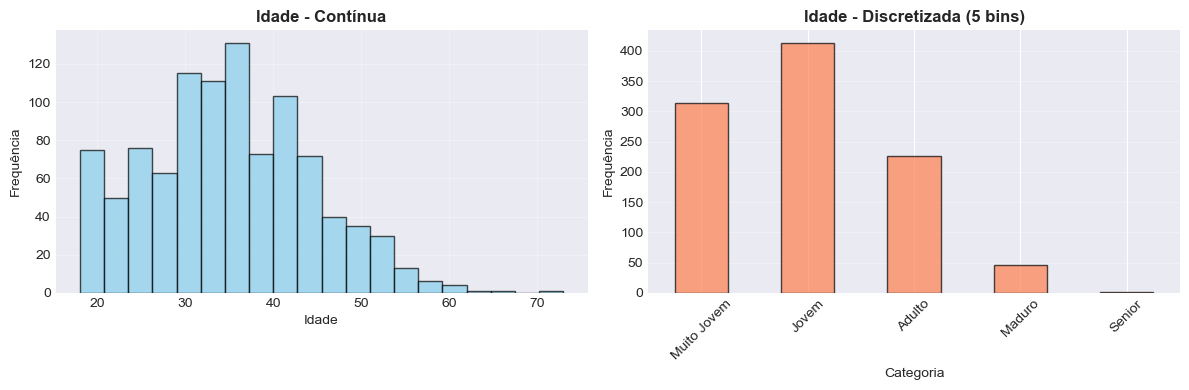

In [20]:
# Binning na idade com intervalos iguais
df_binning = df.copy()

df_binning['idade_bins'] = pd.cut(
    df_binning['idade'], 
    bins=5, 
    labels=['Muito Jovem', 'Jovem', 'Adulto', 'Maduro', 'Senior']
)

print("✅ Binning com Cut aplicado!\n")
print("📊 Distribuição dos bins:")
print(df_binning['idade_bins'].value_counts().sort_index())

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original
axes[0].hist(df_binning['idade'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Idade - Contínua', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Idade')
axes[0].set_ylabel('Frequência')
axes[0].grid(True, alpha=0.3)

# Binned
df_binning['idade_bins'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='coral', alpha=0.7, edgecolor='black')
axes[1].set_title('Idade - Discretizada (5 bins)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Categoria')
axes[1].set_ylabel('Frequência')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 3.2 Qcut - Quantis (mesma quantidade por bin)

✅ Binning com Qcut aplicado!

📊 Distribuição dos quartis (sempre iguais):
salario_quartis
Q1-Baixo          250
Q2-Médio-Baixo    250
Q3-Médio-Alto     250
Q4-Alto           250
Name: count, dtype: int64


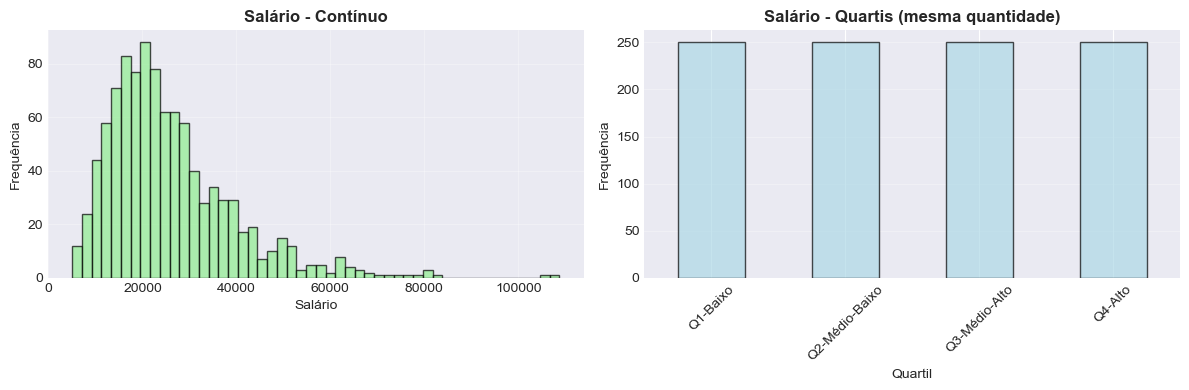


📊 Intervalos dos quartis:
                   min     max  count
salario_quartis                      
Q1-Baixo          5063   16253    250
Q2-Médio-Baixo   16271   22716    250
Q3-Médio-Alto    22748   31691    250
Q4-Alto          31771  108722    250


In [21]:
# Binning com quantis no salário
df_binning['salario_quartis'] = pd.qcut(
    df_binning['salario'], 
    q=4, 
    labels=['Q1-Baixo', 'Q2-Médio-Baixo', 'Q3-Médio-Alto', 'Q4-Alto']
)

print("✅ Binning com Qcut aplicado!\n")
print("📊 Distribuição dos quartis (sempre iguais):")
print(df_binning['salario_quartis'].value_counts().sort_index())

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histograma original
axes[0].hist(df_binning['salario'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0].set_title('Salário - Contínuo', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Salário')
axes[0].set_ylabel('Frequência')
axes[0].grid(True, alpha=0.3)

# Quartis
df_binning['salario_quartis'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='lightblue', alpha=0.7, edgecolor='black')
axes[1].set_title('Salário - Quartis (mesma quantidade)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Quartil')
axes[1].set_ylabel('Frequência')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Intervalos dos quartis:")
quartiles = df_binning.groupby('salario_quartis')['salario'].agg(['min', 'max', 'count'])
print(quartiles)

### 3.3 Binning Customizado

✅ Binning Customizado aplicado!

📊 Distribuição por nível salarial:
salario_nivel
Entrada      718
Pleno        224
Senior        52
Executivo      6
Name: count, dtype: int64


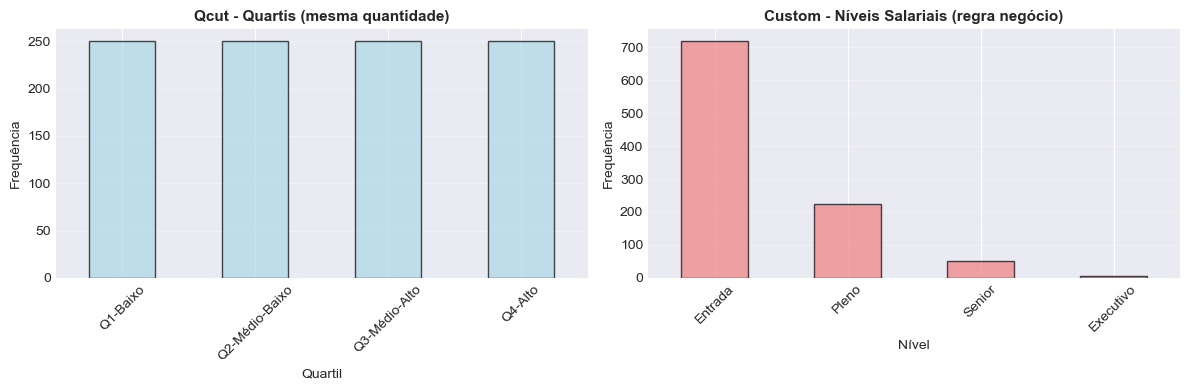


📌 Diferenças:
- Qcut: Garante mesma quantidade em cada bin
- Custom: Reflete regras de negócio (pode ter bins desiguais)


In [22]:
# Binning customizado baseado em regras de negócio
bins_custom = [0, 30000, 50000, 80000, float('inf')]
labels_custom = ['Entrada', 'Pleno', 'Senior', 'Executivo']

df_binning['salario_nivel'] = pd.cut(
    df_binning['salario'],
    bins=bins_custom,
    labels=labels_custom
)

print("✅ Binning Customizado aplicado!\n")
print("📊 Distribuição por nível salarial:")
print(df_binning['salario_nivel'].value_counts().sort_index())

# Visualizar diferença entre Cut, Qcut e Custom
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Qcut (quantis)
df_binning['salario_quartis'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='lightblue', alpha=0.7, edgecolor='black')
axes[0].set_title('Qcut - Quartis (mesma quantidade)', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Quartil')
axes[0].set_ylabel('Frequência')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Custom (negócio)
df_binning['salario_nivel'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='lightcoral', alpha=0.7, edgecolor='black')
axes[1].set_title('Custom - Níveis Salariais (regra negócio)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Nível')
axes[1].set_ylabel('Frequência')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📌 Diferenças:")
print("- Qcut: Garante mesma quantidade em cada bin")
print("- Custom: Reflete regras de negócio (pode ter bins desiguais)")

## 🎯 4. Impacto no Modelo ML

Vamos comparar a performance de modelos com diferentes transformações.

In [23]:
# Preparar diferentes versões dos dados
X_original = df[features]
y_target = df['satisfeito']

datasets = {
    'Original': X_original,
    'StandardScaler': X_standard,
    'MinMaxScaler': X_minmax,
    'RobustScaler': X_robust,
}

# Testar com Logistic Regression (sensível a escala)
print("🔍 Testando com Logistic Regression (sensível a escala)\n")
results_lr = {}

for name, X_data in datasets.items():
    lr = LogisticRegression(random_state=42, max_iter=1000)
    scores = cross_val_score(lr, X_data, y_target, cv=5, scoring='accuracy')
    results_lr[name] = scores.mean()
    print(f"{name:20s}: {scores.mean():.4f} (+/- {scores.std():.4f})")

print("\n" + "="*60)

# Testar com Random Forest (não sensível a escala)
print("\n🌲 Testando com Random Forest (não sensível a escala)\n")
results_rf = {}

for name, X_data in datasets.items():
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(rf, X_data, y_target, cv=5, scoring='accuracy')
    results_rf[name] = scores.mean()
    print(f"{name:20s}: {scores.mean():.4f} (+/- {scores.std():.4f})")

print("\n" + "="*60)

🔍 Testando com Logistic Regression (sensível a escala)

Original            : 0.8060 (+/- 0.0248)
StandardScaler      : 0.8060 (+/- 0.0248)
MinMaxScaler        : 0.7820 (+/- 0.0240)
RobustScaler        : 0.8060 (+/- 0.0248)


🌲 Testando com Random Forest (não sensível a escala)

Original            : 0.8060 (+/- 0.0248)
StandardScaler      : 0.8060 (+/- 0.0248)
MinMaxScaler        : 0.7820 (+/- 0.0240)
RobustScaler        : 0.8060 (+/- 0.0248)


🌲 Testando com Random Forest (não sensível a escala)

Original            : 0.8860 (+/- 0.0107)
Original            : 0.8860 (+/- 0.0107)
StandardScaler      : 0.8860 (+/- 0.0107)
StandardScaler      : 0.8860 (+/- 0.0107)
MinMaxScaler        : 0.8860 (+/- 0.0107)
MinMaxScaler        : 0.8860 (+/- 0.0107)
RobustScaler        : 0.8860 (+/- 0.0107)

RobustScaler        : 0.8860 (+/- 0.0107)



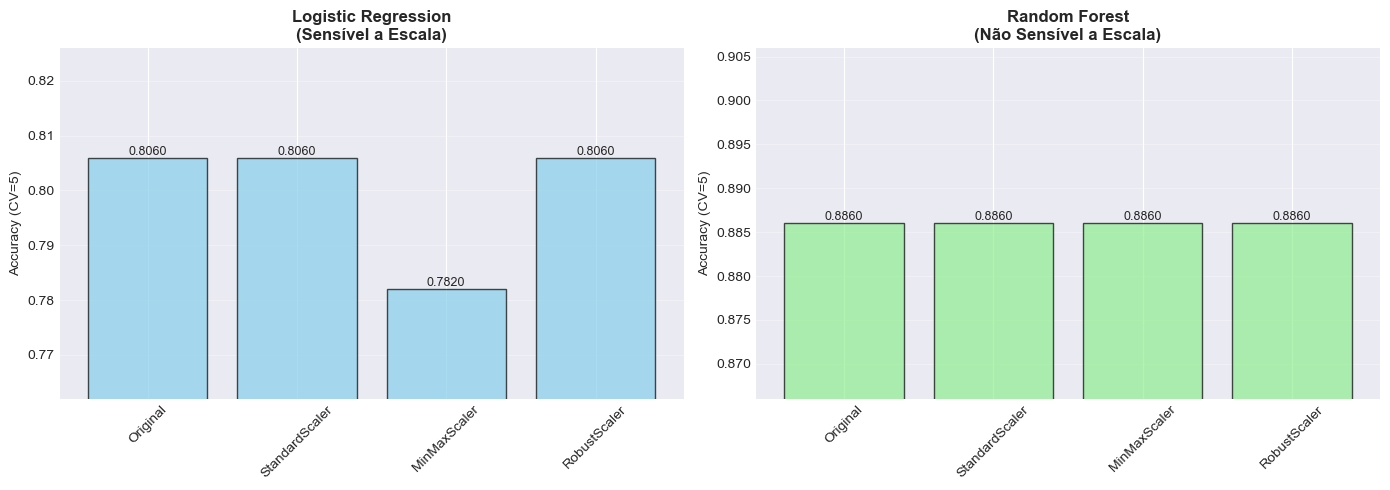


📊 Conclusões:

1️⃣ Logistic Regression:
   🏆 Melhor: Original (0.8060)
   ✅ Scaling fez diferença: 0.0000

2️⃣ Random Forest:
   🏆 Melhor: Original (0.8860)
   ✅ Scaling fez pouca diferença (esperado!)

📌 Lição:
   - Algoritmos baseados em distância/gradiente: PRECISAM de scaling
   - Algoritmos baseados em árvores: NÃO precisam de scaling


In [24]:
# Visualizar comparação
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression
bars1 = axes[0].bar(results_lr.keys(), results_lr.values(), alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Logistic Regression\n(Sensível a Escala)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy (CV=5)')
axes[0].set_ylim([min(results_lr.values()) - 0.02, max(results_lr.values()) + 0.02])
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Random Forest
bars2 = axes[1].bar(results_rf.keys(), results_rf.values(), alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].set_title('Random Forest\n(Não Sensível a Escala)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy (CV=5)')
axes[1].set_ylim([min(results_rf.values()) - 0.02, max(results_rf.values()) + 0.02])
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Conclusões
print("\n📊 Conclusões:")
print("\n1️⃣ Logistic Regression:")
best_lr = max(results_lr.items(), key=lambda x: x[1])
print(f"   🏆 Melhor: {best_lr[0]} ({best_lr[1]:.4f})")
print(f"   ✅ Scaling fez diferença: {best_lr[1] - results_lr['Original']:.4f}")

print("\n2️⃣ Random Forest:")
best_rf = max(results_rf.items(), key=lambda x: x[1])
print(f"   🏆 Melhor: {best_rf[0]} ({best_rf[1]:.4f})")
print(f"   ✅ Scaling fez pouca diferença (esperado!)")

print("\n📌 Lição:")
print("   - Algoritmos baseados em distância/gradiente: PRECISAM de scaling")
print("   - Algoritmos baseados em árvores: NÃO precisam de scaling")

## ✅ Resumo e Próximos Passos

### 🎯 O que aprendemos?

1. **Scaling e Normalização**
   - StandardScaler: média 0, std 1
   - MinMaxScaler: range [0, 1]
   - RobustScaler: resistente a outliers

2. **Transformações de Distribuição**
   - Log Transform: reduz assimetria
   - Yeo-Johnson: normaliza distribuição

3. **Binning**
   - Cut: intervalos iguais
   - Qcut: quantis (mesma quantidade)
   - Custom: regras de negócio

4. **Impacto no ML**
   - Scaling crucial para LR, SVM, KNN
   - Árvores não precisam de scaling

### 📚 Próximo Notebook

**02b-transformacoes-categoricas.ipynb**
- One-Hot Encoding
- Label Encoding
- Target Encoding
- Frequency Encoding

---

**🎉 Ótimo trabalho! Continue praticando!** 💪